### Imports & Data

In [ ]:
!pip install --q econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 13.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
import statsmodels.formula.api as smf
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [ ]:
pl_data = pd.read_csv('/content/full_data_epl_2015-2023_no_interim.csv')

In [ ]:
pl_data

,team,season,treatment,manager_change_date,pre_goals_scored,pre_goals_conceded,pre_points,pre_home_games,pre_rating,pre_opponent_rating,...,post_points,post_home_games,post_rating,post_opponent_rating,post_avg_rating_gap,post_avg_league_position,scaled_avg_budget,pre_score,post_score,expectation
0,AFC Bournemouth,2016,0,NaN,13,11,14,5,73.000000,76.555556,...,4,5,73.000000,79.333333,-6.333333,12.222222,2.717514,14.135556,7.497222,30.475254
1,AFC Bournemouth,2017,0,NaN,14,21,6,4,74.000000,79.000000,...,15,5,74.000000,78.111111,-4.111111,13.111111,4.585311,9.907778,14.383333,15.755593
2,AFC Bournemouth,2018,0,NaN,11,17,7,5,75.000000,78.222222,...,13,4,75.444444,78.222222,-2.777778,12.222222,5.433333,10.612222,13.330556,13.930000
3,AFC Bournemouth,2019,0,NaN,18,13,19,4,76.000000,77.888889,...,9,5,76.000000,79.000000,-3.000000,7.666667,5.705273,14.345556,9.816667,14.831582
4,AFC Bournemouth,2020,0,NaN,2,16,4,4,76.777778,78.222222,...,4,4,76.000000,78.444444,-2.444444,17.444444,4.918079,7.526667,9.383333,12.610979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Wolverhampton Wanderers,2019,0,NaN,16,13,16,5,76.000000,79.555556,...,12,4,76.666667,78.000000,-1.333333,7.777778,7.440678,13.667778,11.627778,15.752203
177,Wolverhampton Wanderers,2020,0,NaN,14,11,16,4,78.000000,78.666667,...,14,4,78.000000,79.000000,-1.000000,7.333333,5.508475,14.870000,12.933333,14.762542
178,Wolverhampton Wanderers,2021,0,NaN,9,12,11,5,78.444444,78.777778,...,9,4,79.000000,78.444444,0.555556,13.222222,5.830508,10.687778,11.802778,17.568041
179,Wolverhampton Wanderers,2022,0,NaN,10,9,17,4,78.111111,76.333333,...,16,4,78.000000,80.222222,-2.222222,8.444444,5.830508,13.363333,13.572222,19.361375


### IPW

In [ ]:
def ipw(df, treatment, outcome, covariates, plot=False):
    X = df[covariates]
    y = df[treatment]
    log_reg = LogisticRegression(max_iter=1000)
    df['propensity_score'] = log_reg.fit(X, y).predict_proba(X)[:, 1]
    df['weight'] = np.where(df[treatment] == 1,
                        1 / df['propensity_score'],
                        1 / (1 - df['propensity_score']))
    treated = df[df[treatment] == 1]
    control = df[df[treatment] == 0]

    ate_ipw = (
        np.sum(treated[outcome] * treated['weight']) / np.sum(treated['weight']) -
        np.sum(control[outcome] * control['weight']) / np.sum(control['weight']))

    if plot:
      df.groupby('treatment')['propensity_score'].plot(kind='hist', sharex=True, alpha=0.75, range=(0, 1), bins=20)

      print(f"ATE (IPW): {ate_ipw}")
    return ate_ipw

### DiD

In [ ]:
def did(df, treatment, outcome, covariates, plot=False):
    pre_measure = 'pre_score' if outcome == 'post_score' else 'pre_points'
    df['performance_change'] = df[outcome] - df[pre_measure]
    did_model = smf.ols('performance_change ~ treatment + C(season)', data=df).fit()
    ate = did_model.params['treatment']
    if plot:
      print(did_model.summary())
      print(f"ATE (DiD): {ate}")
    return ate

### Causal Forest

In [ ]:
def causal_forest(df, treatment, outcome, covariates, plot=False):
    X = df[covariates]
    T = df[treatment]
    Y = df[outcome]
    causal_forest = CausalForestDML(
        model_t=RandomForestClassifier(),
        model_y=RandomForestRegressor(),
        discrete_treatment=True)
    causal_forest.fit(Y, T, X=X)
    ate = causal_forest.ate(X)
    if plot:
      print(f"ATE (Causal Forests): {ate.mean()}")
    return ate.mean()

### S/T-learner

In [ ]:
def s_learner_linear(df, treatment, outcome, covariates, plot=False):
    X = df[covariates + [treatment]]
    y = df[outcome]
    s_learner_lr = LinearRegression()
    s_learner_lr.fit(X, y)
    df['y_treated'] = s_learner_lr.predict(df[covariates].assign(treatment=1))
    df['y_control'] = s_learner_lr.predict(df[covariates].assign(treatment=0))
    ate_s_learner_lr = (df['y_treated'] - df['y_control']).mean()
    if plot:
      print(f"ATE (S-Learner, Linear Regression): {ate_s_learner_lr}")
    return ate_s_learner_lr

In [ ]:
def s_learner_xgb(df, treatment, outcome, covariates, plot=False):
    X = df[covariates + [treatment]]
    y = df[outcome]
    s_learner_xgb = XGBRegressor()
    s_learner_xgb.fit(X, y)
    df['y_treated_xgb'] = s_learner_xgb.predict(df[covariates].assign(treatment=1))
    df['y_control_xgb'] = s_learner_xgb.predict(df[covariates].assign(treatment=0))
    ate_s_learner_xgb = (df['y_treated_xgb'] - df['y_control_xgb']).mean()
    if plot:
      print(f"ATE (S-Learner, XGBoost): {ate_s_learner_xgb}")
    return ate_s_learner_xgb

In [ ]:
def t_learner_linear(df, treatment, outcome, covariates, plot=False):
    treated_df = df[df[treatment] == 1]
    control_df = df[df[treatment] == 0]
    X_treated = treated_df[covariates]
    y_treated = treated_df[outcome]
    X_control = control_df[covariates]
    y_control = control_df[outcome]
    t_learner_lr_treated = LinearRegression()
    t_learner_lr_control = LinearRegression()
    t_learner_lr_treated.fit(X_treated, y_treated)
    t_learner_lr_control.fit(X_control, y_control)
    df['y_treated_lr'] = t_learner_lr_treated.predict(df[covariates])
    df['y_control_lr'] = t_learner_lr_control.predict(df[covariates])
    ate_t_learner_lr = (df['y_treated_lr'] - df['y_control_lr']).mean()

    if plot:
        print(f"ATE (T-Learner, Linear Regression): {ate_t_learner_lr}")

    return ate_t_learner_lr

In [ ]:
def t_learner_xgb(df, treatment, outcome, covariates, plot=False):
    treated_df = df[df[treatment] == 1]
    control_df = df[df[treatment] == 0]
    X_treated = treated_df[covariates]
    y_treated = treated_df[outcome]
    X_control = control_df[covariates]
    y_control = control_df[outcome]
    t_learner_xgb_treated = XGBRegressor()
    t_learner_xgb_control = XGBRegressor()
    t_learner_xgb_treated.fit(X_treated, y_treated)
    t_learner_xgb_control.fit(X_control, y_control)
    df['y_treated_xgb'] = t_learner_xgb_treated.predict(df[covariates])
    df['y_control_xgb'] = t_learner_xgb_control.predict(df[covariates])
    ate_t_learner_xgb = (df['y_treated_xgb'] - df['y_control_xgb']).mean()

    if plot:
        print(f"ATE (T-Learner, XGBoost): {ate_t_learner_xgb}")

    return ate_t_learner_xgb

In [ ]:
def estimate_t_learner(df: pd.DataFrame, model: str = 'linear'):
    X = df.iloc[:,:59]
    treated = df[df['T']==1]
    control = df[df['T']==0]
    X_treated = treated.iloc[:,:59]
    Y_treated = treated.iloc[:,59]
    X_control = control.iloc[:,:59]
    Y_control = control.iloc[:,59]
    model_treated = LinearRegression() if model == 'linear' else RandomForestRegressor()
    model_treated.fit(X_treated, Y_treated)
    model_control = LinearRegression() if model == 'linear' else RandomForestRegressor()
    model_control.fit(X_control, Y_control)
    y_pred_treated = model_treated.predict(X)
    y_pred_control = model_control.predict(X)
    print((y_pred_treated - y_pred_control).mean())
    return (y_pred_treated - y_pred_control).mean()

### Matching

In [ ]:
def prop_matching(df, treatment, outcome, covariates, plot=False):
    X = df[covariates]
    y = df[treatment]
    model = LogisticRegression(max_iter=1000)
    df['propensity_score'] = model.fit(X, y).predict_proba(X)[:, 1]
    treated = df[df[treatment] == 1]
    control = df[df[treatment] == 0]
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(control[['propensity_score']])
    distances, indices = nn.kneighbors(treated[['propensity_score']])
    control_matched = control.iloc[indices.flatten()]
    matched = pd.concat([treated, control_matched])
    ate = (matched[matched[treatment] == 1][outcome].mean() -
          matched[matched[treatment] == 0][outcome].mean())
    if plot:
      print(f"ATE (Propensity Score Matching): {ate}")
    return ate

In [ ]:
def matching(df, treatment, outcome, covariates, plot=False, matching_field='expectation', caliper=0.1):
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    treated_values = treated[matching_field].values.reshape(-1, 1)
    control_values = control[matching_field].values.reshape(-1, 1)
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(control_values)
    distances, indices = nn.kneighbors(treated_values)
    matched_indices = indices[distances.flatten() <= caliper].flatten()
    matched_treated = treated.iloc[distances.flatten() <= caliper]
    matched_control = control.iloc[matched_indices]
    matched_df = pd.concat([matched_treated, matched_control])
    ate = (matched_df[matched_df[treatment] == 1][outcome].mean() -
          matched_df[matched_df[treatment] == 0][outcome].mean())
    if plot:
      print(f"ATE (Matching): {ate}")
    return ate

### DiD + Matching

In [ ]:
def did_matching(df, treatment, outcome, covariates, plot=False, matching_field='pre_score', caliper=0.1):
    pre_measure = 'pre_score' if outcome == 'post_score' else 'pre_points'
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    treated_values = treated[matching_field].values.reshape(-1, 1)
    control_values = control[matching_field].values.reshape(-1, 1)
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(control_values)
    distances, indices = nn.kneighbors(treated_values)
    matched_indices = indices[distances.flatten() <= caliper].flatten()
    matched_treated = treated.iloc[distances.flatten() <= caliper]
    matched_control = control.iloc[matched_indices]
    matched = pd.concat([matched_treated, matched_control])
    matched['performance_change'] = matched[outcome] - matched[pre_measure]
    did_model_psm = smf.ols(
        'performance_change ~ treatment + C(season)',
        data=matched
    ).fit()
    ate_psm_did = did_model_psm.params['treatment']
    if plot:
      print(did_model_psm.summary())
      print(f"ATE (Matching + DiD): {ate_psm_did}")
    return ate_psm_did

### DiD + IPW

In [ ]:
def ipw_did(df, treatment, outcome, covariates, plot=False):
    X = df[covariates]
    y = df[treatment]
    log_reg = LogisticRegression(max_iter=1000)
    df['propensity_score'] = log_reg.fit(X, y).predict_proba(X)[:, 1]
    df['weight'] = np.where(df[treatment] == 1,
                            1 / df['propensity_score'],
                            1 / (1 - df['propensity_score']))
    pre_measure = 'pre_score' if outcome == 'post_score' else 'pre_points'
    df['performance_change'] = df[outcome] - df[pre_measure]
    did_ipw_model = smf.wls(
        'performance_change ~ treatment + C(season)',
        data=df,
        weights=df['weight']
    ).fit()
    ate_ipw_did = did_ipw_model.params['treatment']
    if plot:
      print(did_ipw_model.summary())
      print(f"ATE (IPW + DiD): {ate_ipw_did}")
    return ate_ipw_did

### Bootstrapping & Refuting

In [ ]:
def bootstrap_ate(df, estimator_func, covariates, n_bootstrap=1000, alpha=0.05, plot=True):
    ates = []
    for _ in range(n_bootstrap):
        bootstrap_sample = df.sample(frac=1, replace=True)
        ates.append(estimator_func(bootstrap_sample, 'treatment', 'post_score', covariates,))

    mean_ate = np.mean(ates)
    lower_ci = np.percentile(ates, 100 * (alpha / 2))
    upper_ci = np.percentile(ates, 100 * (1 - alpha / 2))

    if plot:
        plt.figure(figsize=(8, 5))
        plt.hist(ates, bins=30, alpha=0.7, color="blue", edgecolor="k")
        plt.axvline(mean_ate, color="red", linestyle="--", label=f"Mean ATE: {mean_ate:.3f}")
        plt.axvline(lower_ci, color="green", linestyle="--", label=f"Lower CI: {lower_ci:.3f}")
        plt.axvline(upper_ci, color="green", linestyle="--", label=f"Upper CI: {upper_ci:.3f}")
        plt.title(f"{estimator_func.__name__} Bootstrap Distribution of ATE")
        plt.xlabel("ATE")
        plt.ylabel("Frequency")
        plt.legend()
        #plt.show()
        plt.savefig(f'/content/plots/bootstrap_ate_{estimator_func.__name__}.png')

    return mean_ate, lower_ci, upper_ci, upper_ci - lower_ci

In [ ]:
def refute_with_null_distribution(df, treatment, outcome, covariates, method, n_permutations=1000, plot=True):
    observed_ate = method(df, treatment, outcome, covariates)
    null_ates = []
    for _ in range(n_permutations):
        df_shuffled = df.copy()
        df_shuffled[treatment] = np.random.permutation(df[treatment])

        try:
            null_ate = method(df_shuffled, treatment, outcome, covariates)
            null_ates.append(null_ate)
        except Exception as e:
            print(f"Permutation failed: {e}")
            continue

    null_ates = np.array(null_ates)
    p_value = (np.sum(null_ates >= abs(observed_ate)) + np.sum(null_ates <= -abs(observed_ate))) / len(null_ates)

    if plot:
        plt.figure(figsize=(8, 5))
        plt.hist(null_ates, bins=30, alpha=0.7, color='blue', label='Null Distribution')
        plt.axvline(observed_ate, color='red', linestyle='--', label='Observed ATE')
        plt.title(f'{method.__name__} Null Distribution of ATE')
        plt.xlabel('ATE')
        plt.ylabel('Frequency')
        plt.legend()
        #plt.show()
        plt.savefig(f'/content/plots/null_dist_{method.__name__}.png')

    return {
        "Observed ATE": observed_ate,
        "Null Distribution": null_ates,
        "p-value": p_value
    }

In [ ]:
def plot_multiple_bootstrap_results(results_dict):

    methods = list(results_dict.keys())
    means = [results[0] for results in results_dict.values()]
    lens = [results[3] for results in results_dict.values()]

    lower_errors = [abs(results[0] - results[1]) for results in results_dict.values()]
    upper_errors = [abs(results[2] - results[0]) for results in results_dict.values()]
    error_bars = [lower_errors, upper_errors]

    x = np.arange(len(methods))

    plt.figure(figsize=(10, 6))
    plt.bar(x, means, yerr=error_bars, capsize=5, color="skyblue", alpha=0.8, edgecolor="k")
    plt.xticks(x, methods, rotation=45, ha="right")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.ylabel("Average Treatment Effect (ATE)")
    plt.title("Bootstrap Estimation Results")
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'/content/plots/ates_all.png')

    plt.figure(figsize=(10, 6))
    plt.bar(x, lens, capsize=5, color="skyblue", alpha=0.8, edgecolor="k")
    plt.xticks(x, methods, rotation=45, ha="right")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.ylabel("CI Width")
    plt.title("CI Widths for Bootstrapped Methods")
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'/content/plots/bootstrap_ate_{method.__name__}.png')

### Running

In [ ]:
covariates_all = ['pre_goals_scored', 'pre_goals_conceded', 'pre_points', 'pre_home_games', 'pre_rating', 'pre_opponent_rating', 'pre_avg_rating_gap', 'pre_avg_league_position', 'pre_score',
                  'prev_season_position', 'total_prestige', 'avg_budget', 'expectation']
covariates_aggregated = ['pre_score', 'expectation']
covariates_single =['pre_goals_scored', 'pre_goals_conceded', 'pre_points', 'pre_home_games', 'pre_rating', 'pre_opponent_rating', 'pre_avg_rating_gap', 'pre_avg_league_position',
                    'prev_season_position', 'total_prestige', 'avg_budget']
outcome = 'post_score'
treatment = 'treatment'

In [ ]:
pl_data[['pre_score', 'post_score']].describe()

,pre_score,post_score
count,181.000000,181.000000
mean,11.789002,12.582248
std,2.597932,2.357660
min,5.995556,6.636111
25%,10.022222,10.755556
50%,11.661111,12.516667
75%,13.667778,14.013889
max,18.944444,19.541667


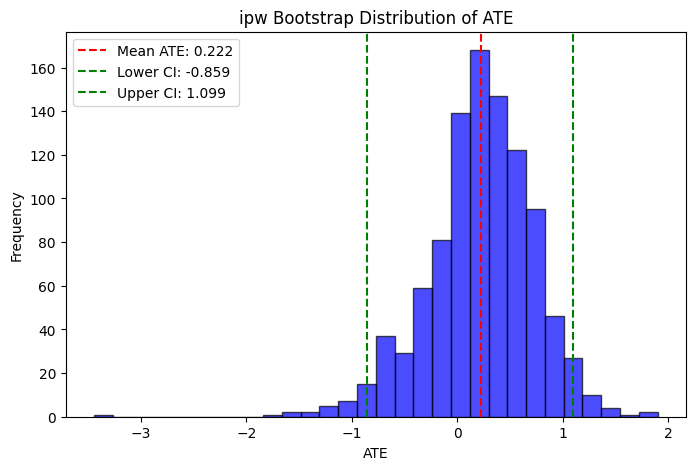

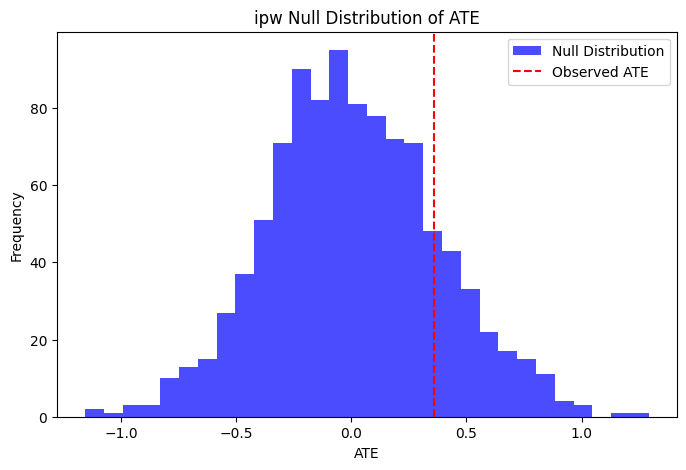

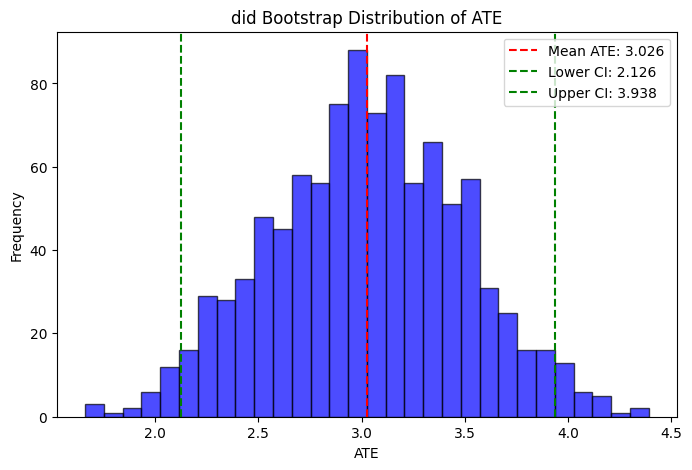

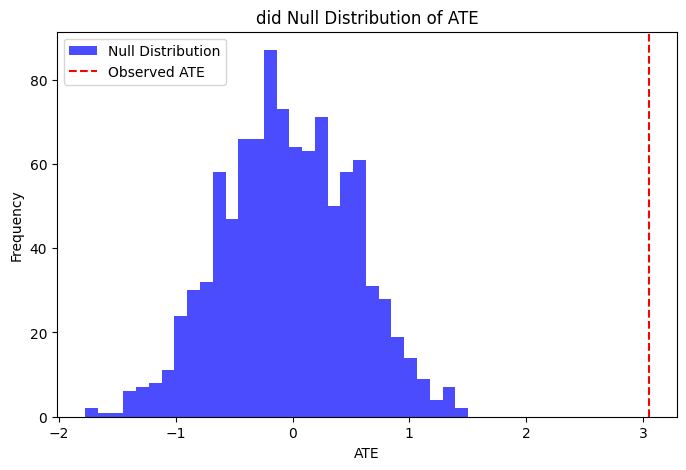

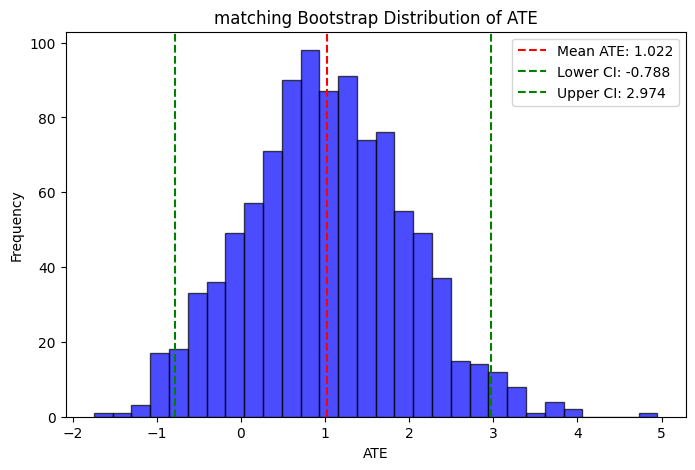

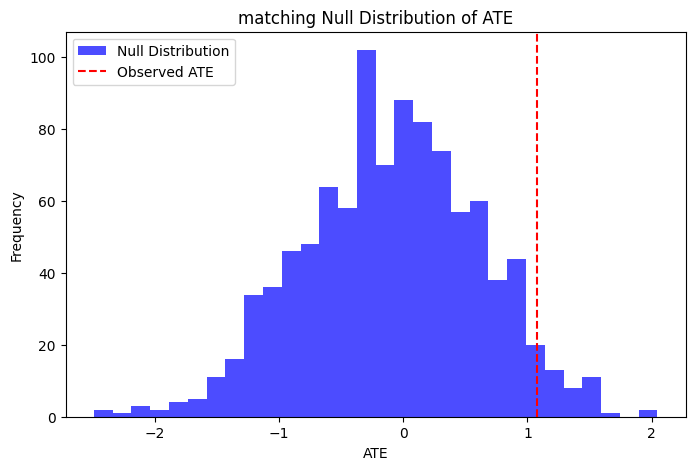

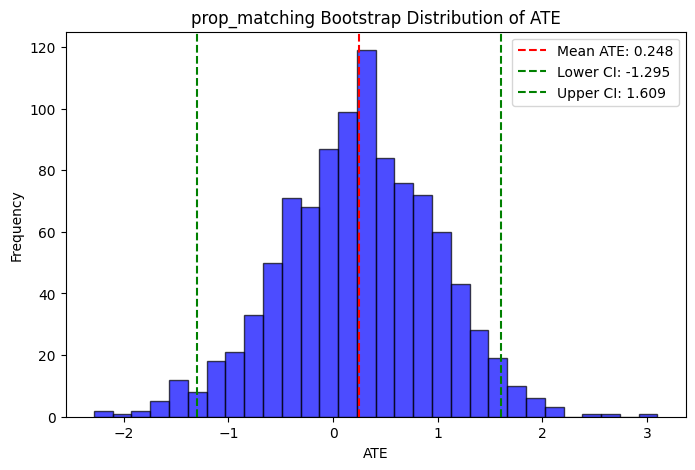

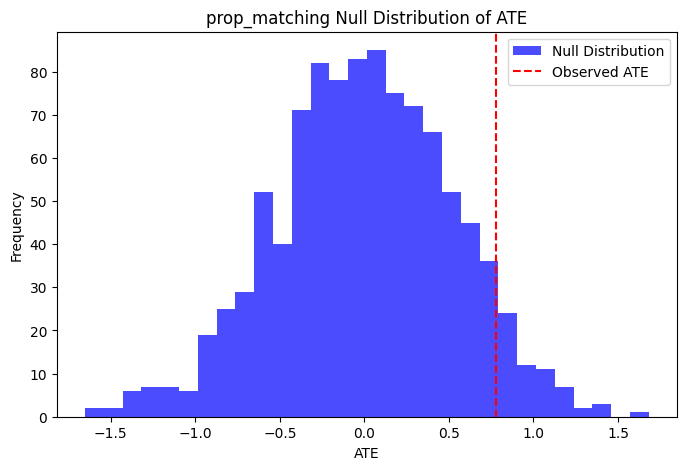

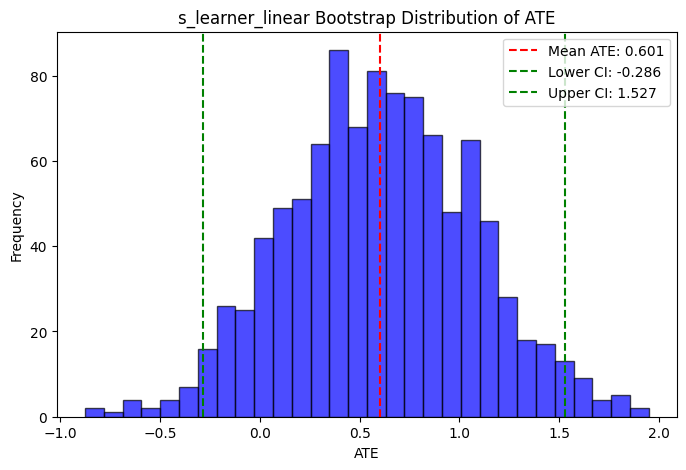

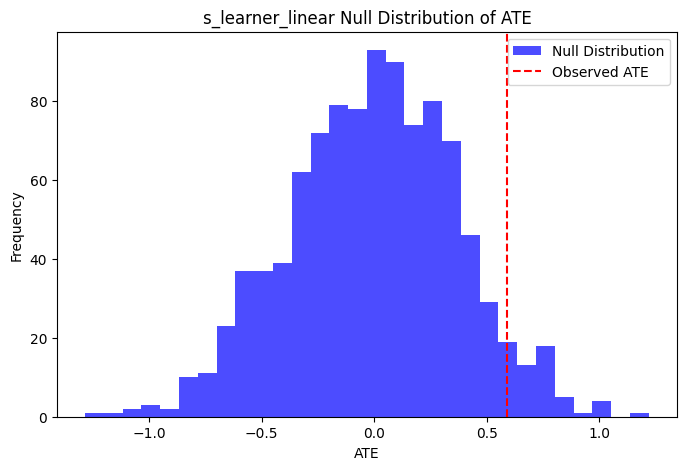

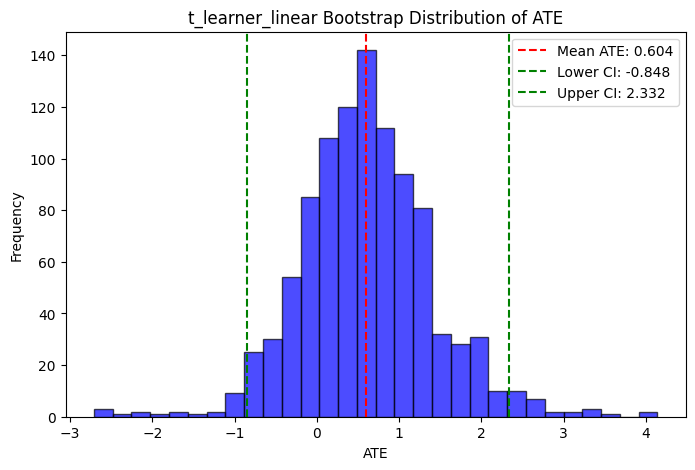

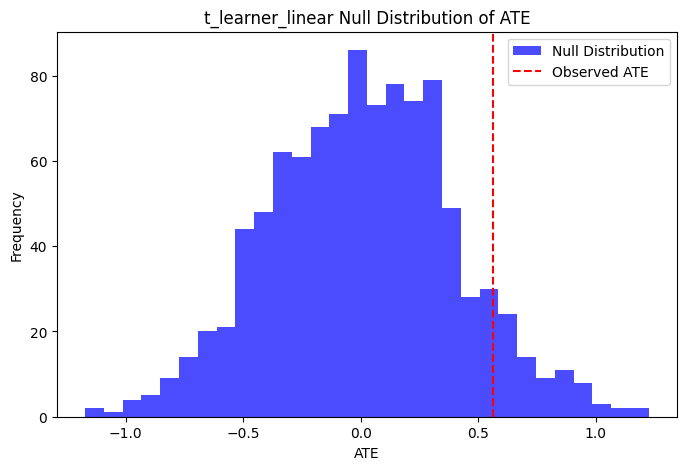

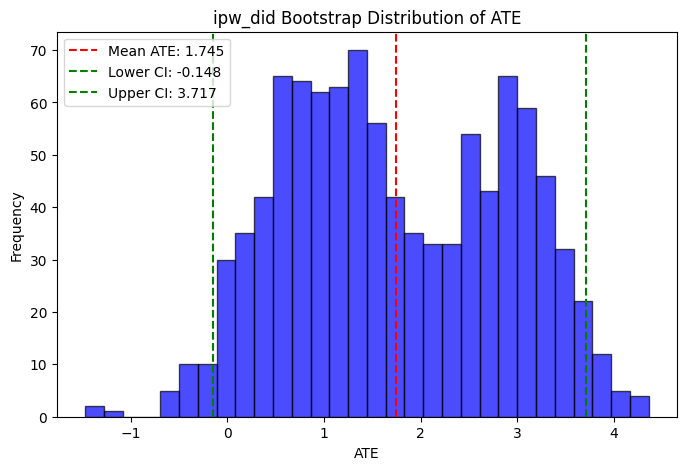

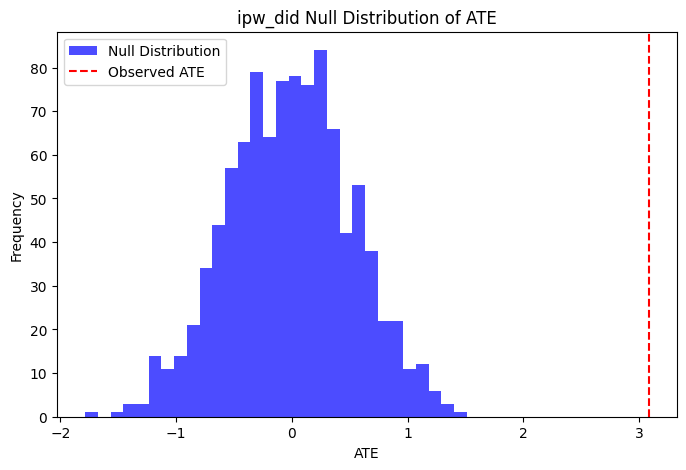

In [ ]:
methods = [ipw, did, matching, prop_matching, s_learner_linear, t_learner_linear, ipw_did]
ate_dict = {}
refute_dict = {}
for method in methods:
    ate_dict[method.__name__] = bootstrap_ate(pl_data, method, covariates_all)
    refute_dict[method.__name__] = refute_with_null_distribution(pl_data, treatment, outcome, covariates_all, method)

In [ ]:
for key, value in refute_dict.items():
    print(f"{key}: {value['p-value']}")

ipw: 0.31
did: 0.0
matching: 0.138
prop_matching: 0.134
s_learner_linear: 0.116
t_learner_linear: 0.143
ipw_did: 0.0


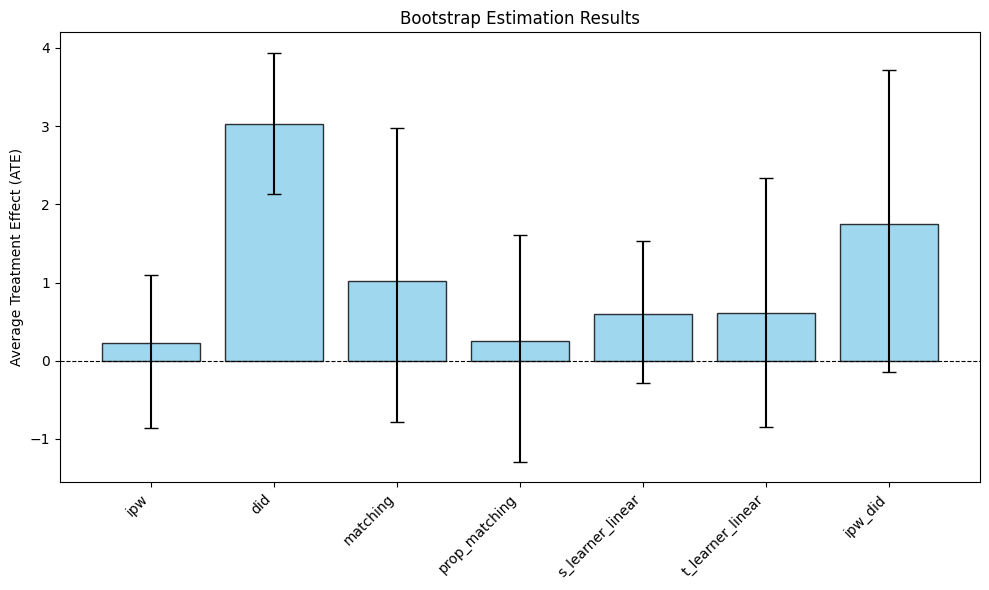

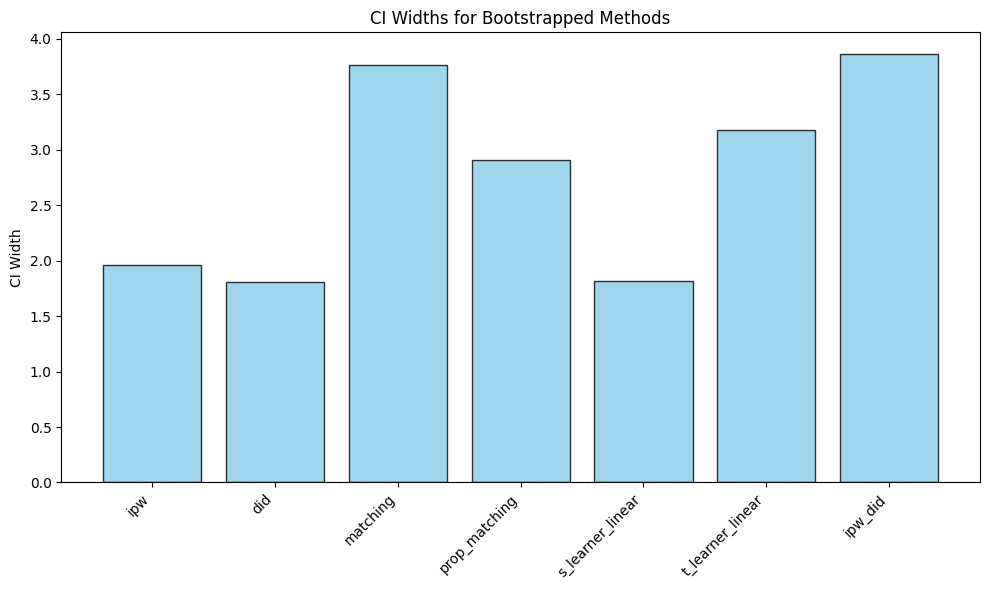

In [ ]:
plot_multiple_bootstrap_results(ate_dict)

In [ ]:
import shutil
from google.colab import files

folder_path = "/content/plots"
zip_file_name = "plots.zip"
shutil.make_archive(zip_file_name.replace(".zip", ""), 'zip', folder_path)
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>